# LangGraph

## LangGraph Usage

### State

In [2]:
load_dotenv()

False

In [3]:
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict
from langchain_core.messages import AIMessage
from langgraph.graph import StateGraph,START,END
import random

In [4]:
class State(TypedDict):
    messages: list[AnyMessage]
    extra_field: int

def node(state: State):
    messages = state["messages"]
    new_message = AIMessage("Hello!")
    return {"messages": messages + [new_message], "extra_field": random.randint(0, 100)}

In [5]:
graph_builder = StateGraph(State)
graph_builder.add_node("node1", node)

# Set entry and finish points
graph_builder.set_entry_point("node1")
graph_builder.set_finish_point("node1")

# Compile the graph
graph = graph_builder.compile()  # Self-loop to keep the graph running

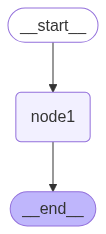

In [6]:
graph

In [7]:
graph.invoke({"messages": [], "extra_field": 0})

{'messages': [AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})],
 'extra_field': 18}

#### with reducer function

In [14]:
from typing_extensions import Annotated
from langchain_core.messages import HumanMessage

def add(left, right):
    """Can also import `add` from the `operator` built-in."""
    print("call reducer function") 
    print(left, right)
    return left + right

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add]
    extra_field: int

def node(state:State):
    new_message = AIMessage("Hello!")
    return {"messages":[new_message], "extra_field": random.randint(0, 100)}

graph = StateGraph(State).add_node(node).set_entry_point("node").compile()

In [19]:
input_message = {"messages": [HumanMessage("Hi")]}

result = graph.invoke(input_message)


call reducer function
[] [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={})]
call reducer function
[HumanMessage(content='Hi', additional_kwargs={}, response_metadata={})] [AIMessage(content='Hello!', additional_kwargs={}, response_metadata={})]


In [21]:
for r in result["messages"]:
    r.pretty_print()

================================ Human Message =================================

Hi
================================== Ai Message ==================================

Hello!


### Node

#### Create Sequence Nodes

In [24]:
import requests
from langgraph.graph.message import add_messages

In [33]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    
def get_request(url: str) -> str:
    """Make a GET request to the specified URL."""
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        return f"Error: {response.status_code}"


def request_google_node(state: State) -> State:
    """Node to make a GET request."""
    url = "https://google.com"  # Example URL
    response_text = get_request(url)
    new_message = AIMessage(response_text)
    return {"messages": [new_message]}

def echo_node(state: State) -> State:
    """Node that echoes the last message content."""
    print("Echo node called")
  
    new_message = AIMessage("Echoing the last message")
    print(new_message)
    return {"messages": [new_message]}


graph_builder = StateGraph(State)

graph_builder.add_node("request_google", request_google_node)
graph_builder.add_node("echo", echo_node)
graph_builder.add_edge(START, "request_google")
graph_builder.set_finish_point("echo")

graph_builder.add_edge("request_google", "echo")
graph = graph_builder.compile()

In [35]:
result = graph.invoke({"messages": []})

Echo node called
content='Echoing the last message' additional_kwargs={} response_metadata={}


In [39]:
result["messages"][0]

'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="tr"><head><meta content="text/html; charset=UTF-8" http-equiv="Content-Type"><meta content="/images/branding/googleg/1x/googleg_standard_color_128dp.png" itemprop="image"><title>Google</title><script nonce="wa55m4lI1HMLoMx95j8eCw">(function(){var _g={kEI:\'-kGGaI6mGODM0PEPmayTkQc\',kEXPI:\'0,202854,2,3497442,1086,538661,48791,30022,16105,78218,266578,290044,5241682,36812642,25228681,51196,5,61021,5084,20962,22567,48674,8037,6757,23878,9139,4600,328,6225,1116,49459,3634,9956,15048,15635,30376,28340,42883,11322,353,4100,14780,7758,5826,5773,20001,4949,2662,4719,11805,3261,2990,35,16903,12108,5683,3604,591,5067,1670,6477,3967,9162,9470,648,4225,3,4801,2418,1,3857,1754,1856,494,1470,1014,1,3467,2,4100,2066,1032,1579,7763,3,6834,2747,2,4,1,321,3435,1664,670,27,3,113,3925,1401,16,4746,1446,3,2,2,2,812,519,692,2753,176,406,1,888,4,1894,2,961,244,2714,691,4561,573,310,18,2161,1280,53,278,72,187,4,743,636,31,104,2113,

In [43]:
import operator
from typing import Annotated, Any
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    import time
    time.sleep(5)  # Simulate a delay
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

def d(state: State):
    print(f'Adding "D" to {state["aggregate"]}')
    return {"aggregate": ["D"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_node(d)
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

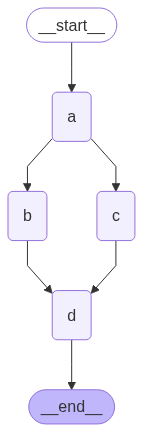

In [44]:
graph

In [45]:
graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})

Adding "A" to []
Adding "B" to ['A']
Adding "C" to ['A']
Adding "D" to ['A', 'B', 'C']


{'aggregate': ['A', 'B', 'C', 'D']}

**there is also a *defer* option to create nodes later**



#### Conditional Edges

In [53]:
import operator
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    aggregate: Annotated[list, operator.add]
    # Add a key to the state. We will set this key to determine
    # how we branch.
    which: str

def a(state: State):
    print(f'Adding "A" to {state["aggregate"]}')
    return {"aggregate": ["A"], "which": "c"}

def b(state: State):
    print(f'Adding "B" to {state["aggregate"]}')
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Adding "C" to {state["aggregate"]}')
    return {"aggregate": ["C"]}

builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)
builder.add_edge(START, "a")
builder.add_edge("b", END)
builder.add_edge("c", END)

def conditional_edge(state: State) -> Literal["b", "c"]:
    # Fill in arbitrary logic here that uses the state
    # to determine the next node
    return state["which"]

builder.add_conditional_edges("a", conditional_edge)

graph = builder.compile()

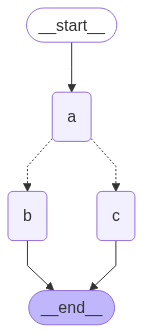

In [54]:
graph

In [50]:
result = graph.invoke({"aggregate": []})
print(result)

Adding "A" to []
Adding "C" to ['A']
{'aggregate': ['A', 'C'], 'which': 'c'}


In [67]:
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    aggregate: Annotated[list, operator.add]

def a(state: State):
    print(f'Node A sees {state["aggregate"]}')
    return {"aggregate": ["A"]}

def b(state: State):
    print(f'Node B sees {state["aggregate"]}')
    import time
    time.sleep(2)  # Simulate a delay
    return {"aggregate": ["B"]}

def c(state: State):
    print(f'Node C sees {state["aggregate"]}')
    return {"aggregate": ["C"]}

# Define nodes
builder = StateGraph(State)
builder.add_node(a)
builder.add_node(b)
builder.add_node(c)

# Define edges
def route(state: State) -> Literal["b", "c"]:
    if len(state["aggregate"]) < 7:
        return "b"
    else:
        return "c"



In [68]:
builder.add_edge(START, "a")
builder.add_conditional_edges("a", route)
builder.add_edge("b", "a")
graph = builder.compile()

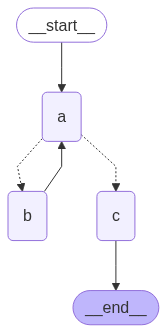

In [69]:
graph

In [70]:
graph.invoke({"aggregate": []})

Node A sees []
Node B sees ['A']
Node A sees ['A', 'B']
Node B sees ['A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B']
Node B sees ['A', 'B', 'A', 'B', 'A']
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']
Node C sees ['A', 'B', 'A', 'B', 'A', 'B', 'A']


{'aggregate': ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'C']}

In [72]:
for step in graph.stream({"aggregate": []}):
    print("=>",step)

Node A sees []
=> {'a': {'aggregate': ['A']}}
Node B sees ['A']
=> {'b': {'aggregate': ['B']}}
Node A sees ['A', 'B']
=> {'a': {'aggregate': ['A']}}
Node B sees ['A', 'B', 'A']
=> {'b': {'aggregate': ['B']}}
Node A sees ['A', 'B', 'A', 'B']
=> {'a': {'aggregate': ['A']}}
Node B sees ['A', 'B', 'A', 'B', 'A']
=> {'b': {'aggregate': ['B']}}
Node A sees ['A', 'B', 'A', 'B', 'A', 'B']
=> {'a': {'aggregate': ['A']}}
Node C sees ['A', 'B', 'A', 'B', 'A', 'B', 'A']
=> {'c': {'aggregate': ['C']}}


### Streaming